In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


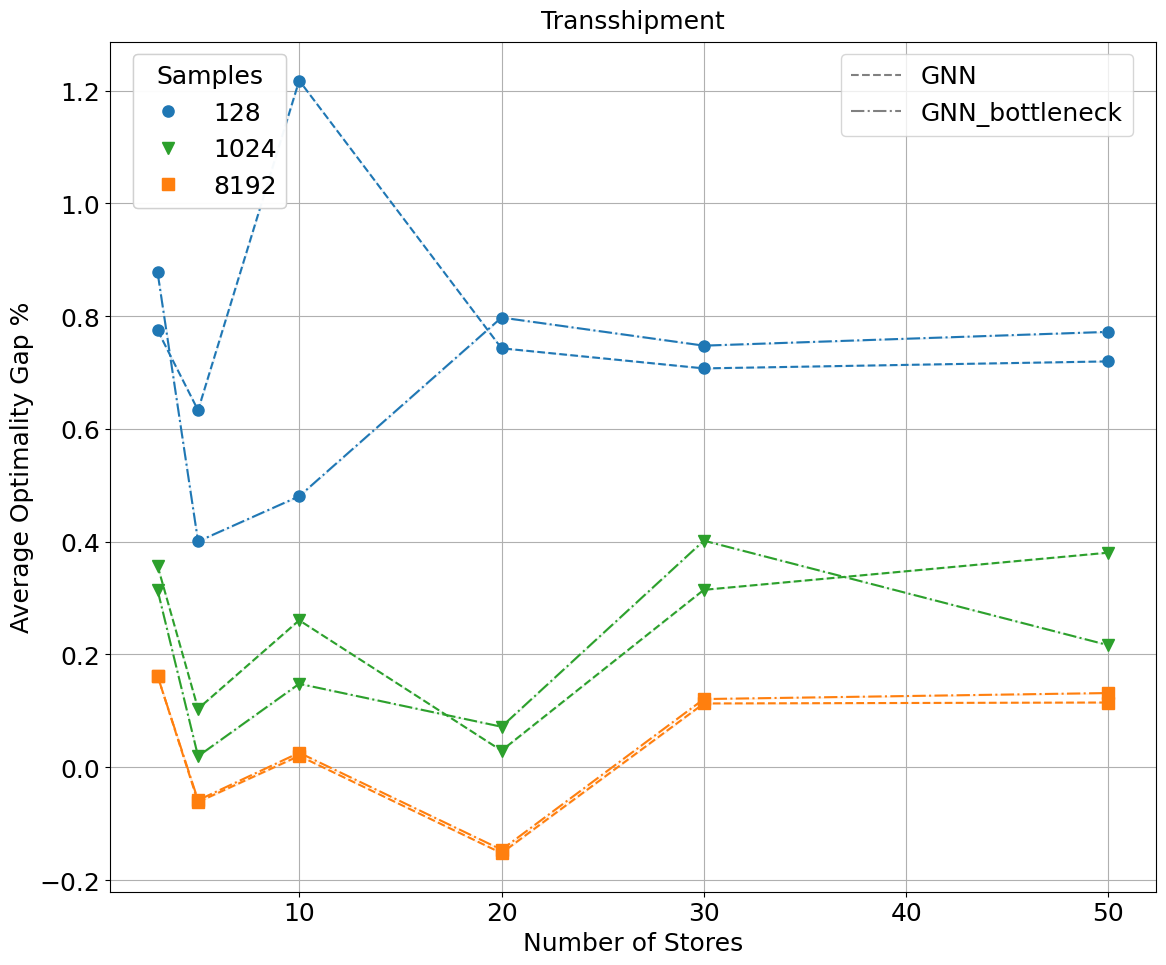

In [9]:
# Lower bound values for different numbers of stores
# 3: 8.533673716946652
# 5: 7.902133198919353
# 10: 8.296968310182638
# 20: 8.731082080524004
# underage costs = tensor(2.1198, dtype=torch.float64)
# holding costs = tensor(6.6113, dtype=torch.float64)

# 30: 8.37732777290095
# 50: 8.118102268777966

# Create vanilla results dataframe from the provided data
testset_name = "finals_transshipment"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    #"Vanilla NN": "-",  # Dashed
    "GNN": "--",         # Solid
    "GNN_bottleneck": "-.",         # Solid
}
# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    #"Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment',
    "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment',
    "GNN_bottleneck": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_bottleneck_transshipment',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [128, 1024, 8192]

# Store lower bounds in a dictionary for easy lookup
lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'store_underage_cost': [9],
                 'store_lead_time': [4],
                 'samples': [1],
                 'n_stores': [n_store]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_stores'] = n_store
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate optimality gap using lower bounds
stats_by_arch_sample_and_stores = {}
for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()  # Create copy to avoid SettingWithCopyWarning
    if store_data.empty:
        continue
    
    lower_bound = lower_bounds[n_store]
    store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100
    
    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []
                
            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Optimality Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })
# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(n_stores_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=8)
        
        plt.fill_between(n_stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)
# Create separate legend entries for architectures and sample sizes
arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=8)
                 for size in color_scheme.keys()]

plt.xlabel('Number of Stores', fontsize=FONTSIZE)
plt.ylabel('Average Optimality Gap %', fontsize=FONTSIZE)
plt.grid(True)

# Create two separate legends
# Right legend for architectures
legend1 = plt.legend(handles=arch_lines, 
                    bbox_to_anchor=(0.99, 1),
                    loc='upper right', 
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

# Left legend for sample sizes with title
legend2 = plt.legend(handles=sample_patches,
                    title='Samples',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
# Add title to the plot
plt.title('Transshipment', fontsize=FONTSIZE, pad=10)
plt.tight_layout()
plt.show()

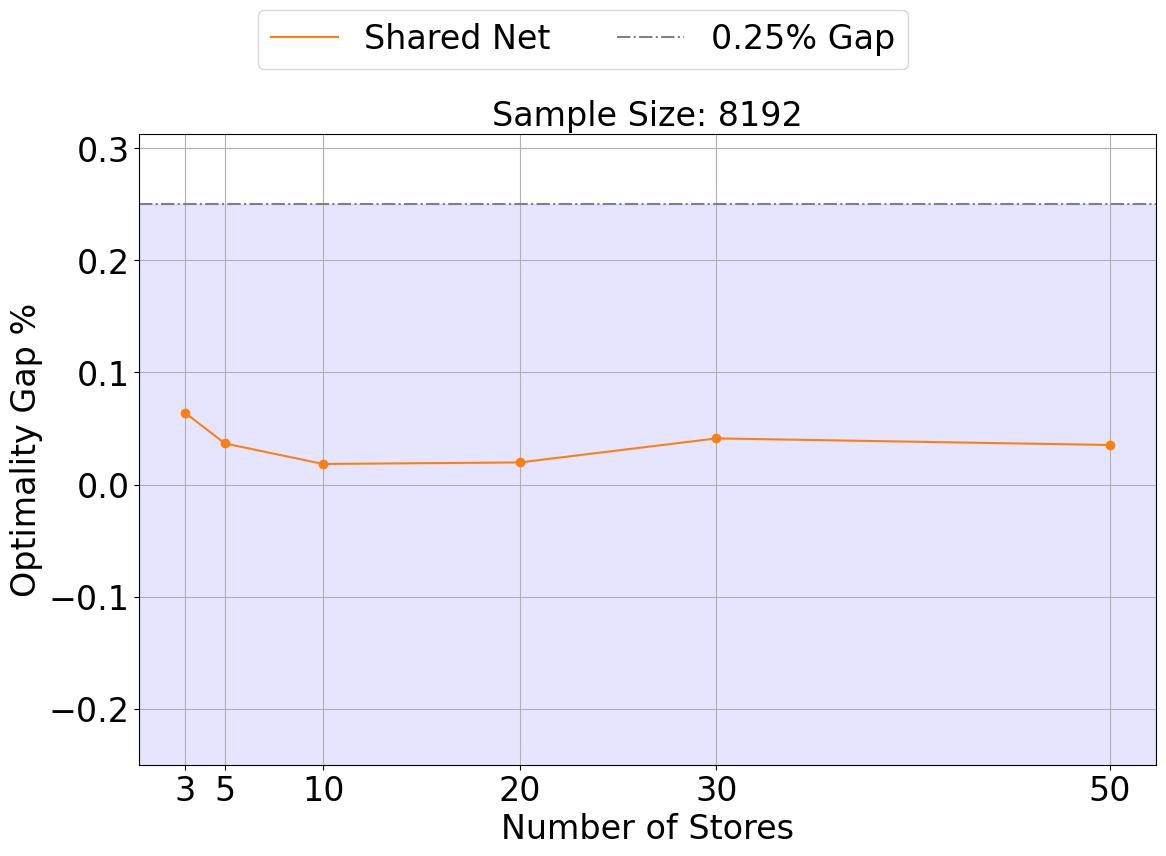

In [17]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Store lower bounds in a dictionary for easy lookup
lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

# Define constants
sample_size = 8192
n_stores_list = [3, 5, 10, 20, 30, 50]

# Define color scheme
color_scheme = {
    "n_stores_shared_net": "#ff7f0e",  # Orange
}

# Function to get relevant indices
def get_relevant_indices(n_samples, batch_size, num_steps, start_step):
    num_batches = n_samples // batch_size
    relevant_indices = []
    for batch in range(num_batches):
        batch_start = batch * batch_size * num_steps
        step_start = batch_start + start_step * batch_size
        step_end = batch_start + num_steps * batch_size
        relevant_indices.extend(range(step_start, step_end))
    return relevant_indices

# Process results for each store configuration
results = {}

# Process data from CSV files
for n_stores in n_stores_list:
    # Set batch size equal to sample size
    batch_size = sample_size
    num_steps = 10000
    start_step = 300
    
    # Get relevant indices
    relevant_indices = get_relevant_indices(sample_size, batch_size, num_steps, start_step)
    
    # Construct the path to the CSV file
    csv_path = f"/user/ml4723/Prj/NIC/analysis/results/transshipment_backlogged_debug/{n_stores}-1/{n_stores}_{sample_size}.csv"
    
    if os.path.exists(csv_path):
        # Read data
        data = pd.read_csv(csv_path)
        if len(data) > 0:
            relevant_data = data.iloc[relevant_indices] if len(data) > max(relevant_indices) else data
            
            # Calculate normalization factor
            normalization_factor = (num_steps - start_step) * n_stores * sample_size
            
            # Get normalized costs
            underage_cost = relevant_data['s_underage_costs'].sum() / normalization_factor
            store_holding_cost = relevant_data['s_holding_costs'].sum() / normalization_factor
            
            # Calculate total cost from normalized components
            total_cost = underage_cost + store_holding_cost
            
            # Get the optimal loss for this number of stores
            optimal_loss = lower_bounds[n_stores]
            
            # Calculate optimality gap
            optimality_gap = ((total_cost - optimal_loss) / optimal_loss) * 100
            results[n_stores] = optimality_gap

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

# Extract data for plotting
store_counts = []
gaps = []

for n_store in n_stores_list:
    if n_store in results:
        store_counts.append(n_store)
        gaps.append(results[n_store])

if store_counts:
    # Plot the data
    ax.plot(store_counts, gaps, marker='o', 
            color=color_scheme["n_stores_shared_net"], 
            linestyle='-', 
            label="n_stores_shared_net")
    
    # Add 0.25% optimality gap reference line
    ax.axhline(y=0.25, color='gray', linestyle='-.', alpha=1.0, label='0.25% Gap')
    ax.axhspan(-1, 0.25, color='blue', alpha=0.1)
    
    font_size = 24
    ax.set_xlabel('Number of Stores', fontsize=font_size)
    ax.set_ylabel('Optimality Gap %', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_title(f'Sample Size: {sample_size}', fontsize=font_size)
    ax.grid(True)
    ax.set_xticks(store_counts)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.set_ylim(bottom=-0.25)

# Create a custom legend
custom_lines = [
    plt.Line2D([0], [0], color=color_scheme["n_stores_shared_net"], linestyle='-', label='Shared Net'),
    plt.Line2D([0], [0], color='gray', linestyle='-.', label='0.25% Gap')
]

fig.legend(handles=custom_lines, loc='upper center', fontsize=font_size, ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.show()